<a href="https://colab.research.google.com/github/malborroni/RECMojion/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerie

In [0]:
! sudo pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-oi2cr64m
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-oi2cr64m
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=4b5ea934889db554ffea52dbeba8322e1dcbbe2ef1ce9eacc2b60feeac9af3ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-dxkdhqno/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [0]:
# Example of face detection with a vggface2 model
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import random as rnd

import seaborn as sns
from matplotlib import style
style.use('seaborn-pastel')

import keras
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import keras_vggface
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input, decode_predictions
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold

import random
import pickle

In [0]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Funzioni

In [0]:
def graph(history):
  # funzione che prende in input il modello fittato e fa un plot della loss in validation e train
  epochs=len(history.history['loss'])
  x_plot = list(range(1,epochs+1))
  plt.figure()
  
  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history.history['loss'])
  plt.plot(x_plot, history.history['val_loss'])
  plt.legend(['Training', 'Validation'])

  
  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.plot(x_plot, history.history['acc'])
  plt.plot(x_plot, history.history['val_acc'])
  plt.legend(['Training', 'Validation'])
  
  plt.tight_layout()
  plt.show()


#Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = np.load('/content/drive/My Drive/Colab Notebooks/AML/data.npz')

In [0]:
# training set
x_train = data['x_train']
y_train = data['y_train']

# validation set
x_val = data['x_val']
y_val = data['y_val']

# test set
x_test = data['x_test']
y_test = data['y_test']

print('Shape del training set: {} --- {}\nShape del validation set: {} --- {}\nShape del test set: {} --- {}'. format(x_train.shape, y_train.shape,
                                                                                                                 x_val.shape, y_val.shape,
                                                                                                                 x_test.shape, y_test.shape))

Shape del training set: (2157, 224, 224, 3) --- (2157,)
Shape del validation set: (415, 224, 224, 3) --- (415,)
Shape del test set: (518, 224, 224, 3) --- (518,)


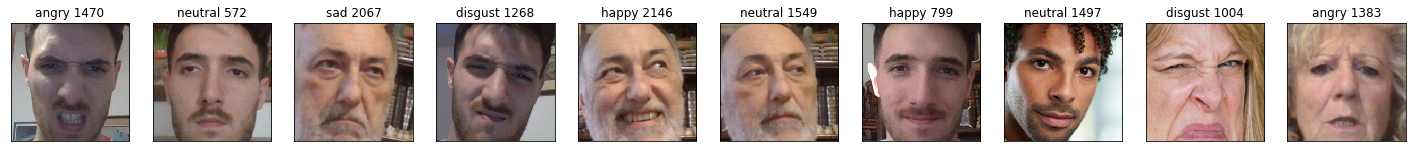

In [0]:
plt.figure(figsize=(25, 8))
nimages = 10 
for i in range(nimages):
    ax = plt.subplot(2, nimages, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    l = random.randint(0, len(y_train))
    plt.imshow(x_train[l][:,:,::-1])
    plt.title(str(y_train[l])+' '+str(l))

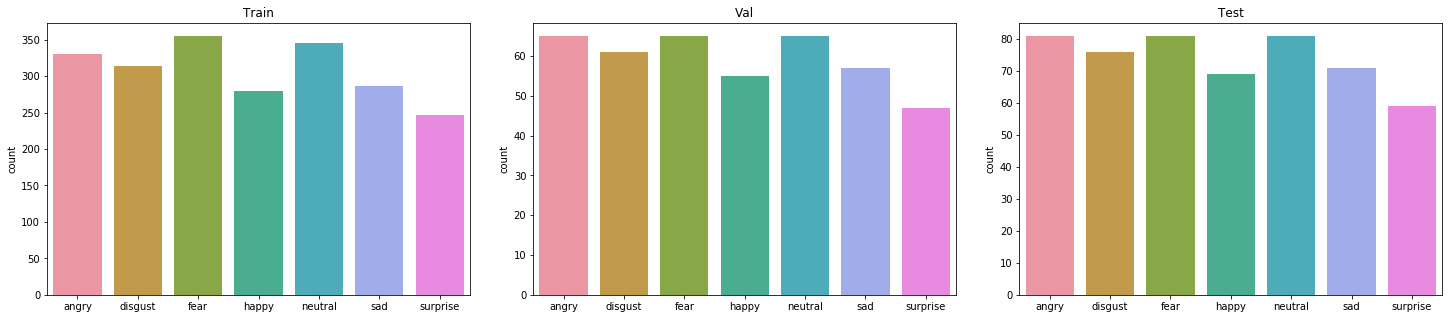

In [0]:
order =  ['angry','disgust','fear','happy','neutral','sad','surprise']

fig = plt.figure(figsize = (25,5))
fig.subplots_adjust(hspace=0, wspace=0.15)
ax = fig.add_subplot(1, 3, 1)
ax.set_title('Train')
sns.countplot(y_train, order = order)
ax = fig.add_subplot(1, 3, 2)
ax.set_title('Val')
sns.countplot(y_val, order = order)
ax = fig.add_subplot(1, 3, 3)
ax.set_title('Test')
sns.countplot(y_test, order = order)
plt.show()

**Preprocessing**

In [0]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = to_categorical(y_train, num_classes = 7)
y_test = le.fit_transform(y_test)
y_test = to_categorical(y_test, num_classes = 7)
y_val = le.fit_transform(y_val)
y_val = to_categorical(y_val, num_classes = 7)

In [0]:
x_train = x_train.astype('float64')
x_test = x_test.astype('float64')
x_val = x_val.astype('float64')
x_train = preprocess_input(x_train, version=2)
x_test = preprocess_input(x_test, version=2)
x_val = preprocess_input(x_val, version=2)

In [0]:
np.max(x_train), np.min(x_train), x_train.shape, np.max(x_val), np.min(x_val), x_val.shape, np.max(x_test), np.min(x_test), x_test.shape

(163.5047,
 -131.0912,
 (2157, 224, 224, 3),
 163.5047,
 -131.0912,
 (415, 224, 224, 3),
 163.5047,
 -131.0912,
 (518, 224, 224, 3))

## Feature Extration

In [0]:
base_model = VGGFace(include_top = False, input_shape = (224, 224, 3), model='senet50')
base_model.summary()














Model: "vggface_senet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
_______________________________________________________________________

Definizione del ciclo per trovare il taglio migliore (sulla base di 3 prove, e valore medio di accuracy)

Vengono tagliati solo a layer che hanno shape maggiore di (1, 1, ...) in quanto per la struttura della CNN vogliamo avere tensori con certe dimensioni

In [0]:
# config model
batch_size = 128
num_epoch = 100

# callbacks
filepath = "/content/drive/My Drive/Colab Notebooks/AML/cnn.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1,restore_best_weights=True) 
callbacks_list = [early_stop, checkpoint]

acc_scores= []
loss_scores = []
namelayer = []
fold = 3

start_layer = 'conv3_4_1x1_reduce'
end_layer = 'conv5_3_1x1_increase/bn' 
flag = 1

#base_model = VGGFace(include_top = False, input_shape = (224, 224, 3), model='senet50')
for layer in base_model.layers:
  if len(layer.output_shape[1:]) == 3 and layer.output_shape[1]>1:
    if layer.name == start_layer or flag == 0:
      
      acc_scores_tmp = []
      loss_scores_tmp = []

      layer_cut = layer.name
      model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_cut).output)
      x_train_fe = model.predict(x_train)
      x_val_fe = model.predict(x_val)
      x_test_fe = model.predict(x_test)
      print('Start in layer: {}'.format(layer_cut))
      for i in range(fold):
        print('Start {}/{}'.format(i+1, fold))
        # Create model
        model = Sequential()
        # C1
        in_shape = layer.output_shape[1:]
        model.add(Conv2D(32, kernel_size=1, activation='relu', input_shape= x_train_fe.shape[1:]))
        model.add(Conv2D(128, kernel_size=3, activation='relu'))
        model.add(Conv2D(32, kernel_size=1, activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        # D
        model.add(Dense(210, activation='relu', kernel_regularizer=regularizers.l2(0.01))) # 21-28-56 buono 224 best
        model.add(Dropout(0.5)) # 0.5
        model.add(Dense(7, activation='softmax'))
        # Compile model
        model.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adam(),
                    metrics=['acc'])
        
        # Fit the model
        model_log = model.fit(x_train_fe, y_train,
                batch_size=batch_size,
                epochs=num_epoch,
                verbose=0,
                validation_data=(x_val_fe, y_val),
                callbacks=callbacks_list)

        # visualize graph
        graph(model_log)

        # Evaluate the model
        # model.load_weights(filepath)
        scores = model.evaluate(x_test_fe, y_test, verbose=1)
        accuracy = 100*scores[1]
        loss = scores[0]
        print("Post-training accuracy: {} %".format(round(accuracy, 3)))
        print("Post-training loss: {}".format(round(loss, 4)))
        acc_scores_tmp.append(accuracy)
        loss_scores_tmp.append(loss)
        flag = 0

      acc_scores.append(np.mean(acc_scores_tmp))
      loss_scores.append(np.mean(loss_scores_tmp))
      namelayer.append(layer.name)

    if layer.name == end_layer:
      break
    


migliore

In [0]:
namelayer[acc_scores.index(max(acc_scores))], max(acc_scores), len(acc_scores)

('activation_51', 92.02059202826314, 111)

In [0]:
import json

In [0]:
result_layers = {'layer': namelayer, 'acc_mean': acc_scores, 'loss_mean': loss_scores}
json = json.dumps(result_layers)

f = open("/content/drive/My Drive/Colab Notebooks/AML/result_layers.json","w")
f.write(json)
f.close()

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/AML/result_layers.json', 'r') as fh:
    result_layers = json.load(fh)

In [0]:
df = pd.DataFrame(result_layers)

In [0]:
df.head()

,layer,acc_mean,loss_mean
0,conv3_4_1x1_reduce,88.931789,0.603527
1,conv3_4_1x1_reduce/bn,89.510940,0.573897
2,activation_32,90.218790,0.516568
3,conv3_4_3x3,89.382239,0.594429
4,conv3_4_3x3/bn,88.996139,0.575715


In [0]:
df.to_csv('/content/drive/My Drive/Colab Notebooks/AML/result_layers.csv')

In [0]:
df['layer'][df['acc_mean'].idxmax()]

'activation_51'

In [0]:
df['layer'][df['acc_mean'].idxmax()]+' acc: '+str(round(max(df['acc_mean']), 2))

'activation_51 acc: 92.02'

Visualizzazione dei valori

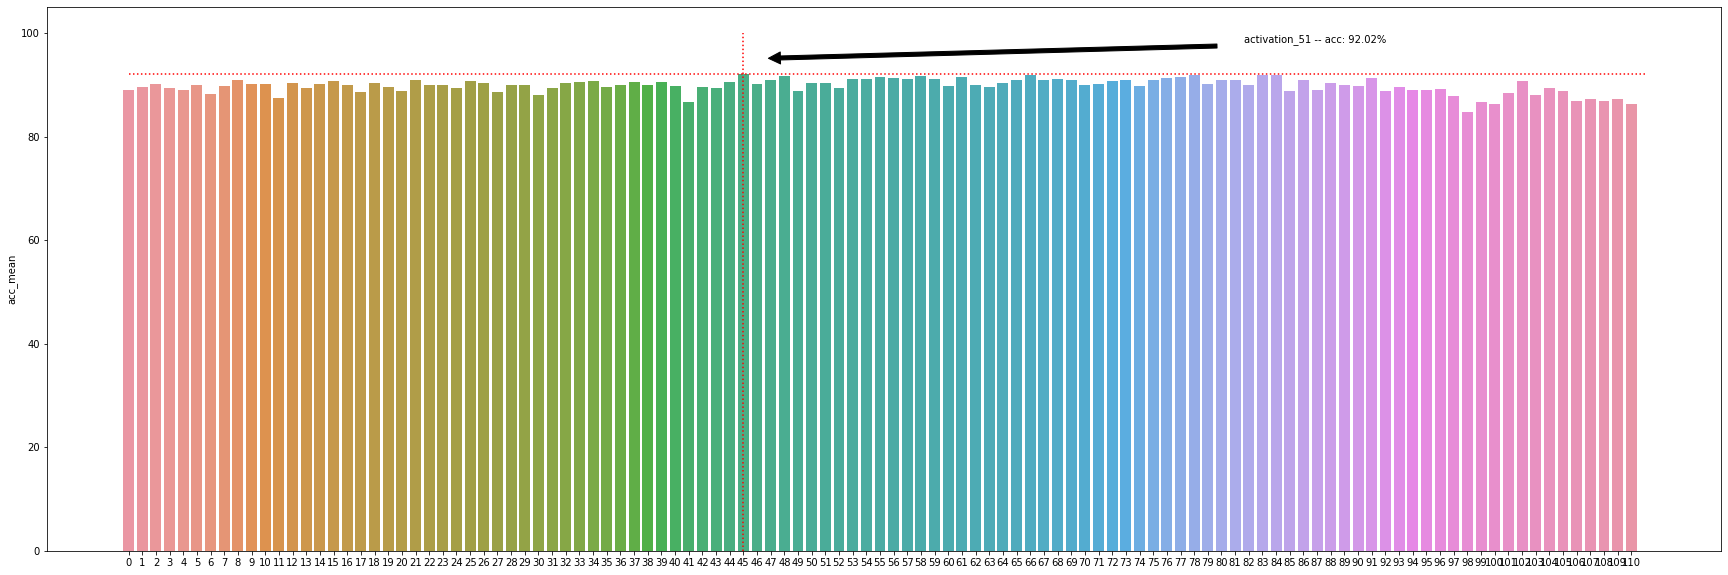

In [0]:
plt.figure(figsize=(30,10))
sns.barplot(x=df['layer'].index, y=df['acc_mean'])
plt.hlines(max(df['acc_mean']), 0, len(df['acc_mean']), linestyles = ':', colors='red')
textAnn = df['layer'][df['acc_mean'].idxmax()]+' -- acc: '+str(round(max(df['acc_mean']), 2))+'%'
plt.annotate(textAnn, xy=(45, 95),  xycoords='data',
            xytext=(0.8, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )
plt.vlines(df['acc_mean'].idxmax(), 0, 100, linestyles = ':', colors = 'r')

Lista dei layer scansionati

In [0]:
conv3_4_1x1_reduce (28, 28, 128)
conv3_4_1x1_reduce/bn (28, 28, 128)
activation_32 (28, 28, 128)
conv3_4_3x3 (28, 28, 128)
conv3_4_3x3/bn (28, 28, 128)
activation_33 (28, 28, 128)
conv3_4_1x1_increase (28, 28, 512)
conv3_4_1x1_increase/bn (28, 28, 512)
global_average_pooling2d_7 (512,)
reshape_7 (1, 1, 512)
conv3_4_1x1_down (1, 1, 32)
activation_34 (1, 1, 32)
conv3_4_1x1_up (1, 1, 512)
activation_35 (1, 1, 512)
multiply_7 (28, 28, 512)
add_7 (28, 28, 512)
activation_36 (28, 28, 512)
conv4_1_1x1_reduce (14, 14, 256)
conv4_1_1x1_reduce/bn (14, 14, 256)
activation_37 (14, 14, 256)
conv4_1_3x3 (14, 14, 256)
conv4_1_3x3/bn (14, 14, 256)
activation_38 (14, 14, 256)
conv4_1_1x1_increase (14, 14, 1024)
conv4_1_1x1_increase/bn (14, 14, 1024)
global_average_pooling2d_8 (1024,)
reshape_8 (1, 1, 1024)
conv4_1_1x1_down (1, 1, 64)
activation_39 (1, 1, 64)
conv4_1_1x1_up (1, 1, 1024)
activation_40 (1, 1, 1024)
conv4_1_1x1_proj (14, 14, 1024)
multiply_8 (14, 14, 1024)
conv4_1_1x1_proj/bn (14, 14, 1024)
add_8 (14, 14, 1024)
activation_41 (14, 14, 1024)
conv4_2_1x1_reduce (14, 14, 256)
conv4_2_1x1_reduce/bn (14, 14, 256)
activation_42 (14, 14, 256)
conv4_2_3x3 (14, 14, 256)
conv4_2_3x3/bn (14, 14, 256)
activation_43 (14, 14, 256)
conv4_2_1x1_increase (14, 14, 1024)
conv4_2_1x1_increase/bn (14, 14, 1024)
global_average_pooling2d_9 (1024,)
reshape_9 (1, 1, 1024)
conv4_2_1x1_down (1, 1, 64)
activation_44 (1, 1, 64)
conv4_2_1x1_up (1, 1, 1024)
activation_45 (1, 1, 1024)
multiply_9 (14, 14, 1024)
add_9 (14, 14, 1024)
activation_46 (14, 14, 1024)
conv4_3_1x1_reduce (14, 14, 256)
conv4_3_1x1_reduce/bn (14, 14, 256)
activation_47 (14, 14, 256)
conv4_3_3x3 (14, 14, 256)
conv4_3_3x3/bn (14, 14, 256)
activation_48 (14, 14, 256)
conv4_3_1x1_increase (14, 14, 1024)
conv4_3_1x1_increase/bn (14, 14, 1024)
global_average_pooling2d_10 (1024,)
reshape_10 (1, 1, 1024)
conv4_3_1x1_down (1, 1, 64)
activation_49 (1, 1, 64)
conv4_3_1x1_up (1, 1, 1024)
activation_50 (1, 1, 1024)
multiply_10 (14, 14, 1024)
add_10 (14, 14, 1024)
activation_51 (14, 14, 1024)
conv4_4_1x1_reduce (14, 14, 256)
conv4_4_1x1_reduce/bn (14, 14, 256)
activation_52 (14, 14, 256)
conv4_4_3x3 (14, 14, 256)
conv4_4_3x3/bn (14, 14, 256)
activation_53 (14, 14, 256)
conv4_4_1x1_increase (14, 14, 1024)
conv4_4_1x1_increase/bn (14, 14, 1024)
global_average_pooling2d_11 (1024,)
reshape_11 (1, 1, 1024)
conv4_4_1x1_down (1, 1, 64)
activation_54 (1, 1, 64)
conv4_4_1x1_up (1, 1, 1024)
activation_55 (1, 1, 1024)
multiply_11 (14, 14, 1024)
add_11 (14, 14, 1024)
activation_56 (14, 14, 1024)
conv4_5_1x1_reduce (14, 14, 256)
conv4_5_1x1_reduce/bn (14, 14, 256)
activation_57 (14, 14, 256)
conv4_5_3x3 (14, 14, 256)
conv4_5_3x3/bn (14, 14, 256)
activation_58 (14, 14, 256)
conv4_5_1x1_increase (14, 14, 1024)
conv4_5_1x1_increase/bn (14, 14, 1024)
global_average_pooling2d_12 (1024,)
reshape_12 (1, 1, 1024)
conv4_5_1x1_down (1, 1, 64)
activation_59 (1, 1, 64)
conv4_5_1x1_up (1, 1, 1024)
activation_60 (1, 1, 1024)
multiply_12 (14, 14, 1024)
add_12 (14, 14, 1024)
activation_61 (14, 14, 1024)
conv4_6_1x1_reduce (14, 14, 256)
conv4_6_1x1_reduce/bn (14, 14, 256)
activation_62 (14, 14, 256)
conv4_6_3x3 (14, 14, 256)
conv4_6_3x3/bn (14, 14, 256)
activation_63 (14, 14, 256)
conv4_6_1x1_increase (14, 14, 1024)
conv4_6_1x1_increase/bn (14, 14, 1024)
global_average_pooling2d_13 (1024,)
reshape_13 (1, 1, 1024)
conv4_6_1x1_down (1, 1, 64)
activation_64 (1, 1, 64)
conv4_6_1x1_up (1, 1, 1024)
activation_65 (1, 1, 1024)
multiply_13 (14, 14, 1024)
add_13 (14, 14, 1024)
activation_66 (14, 14, 1024)
conv5_1_1x1_reduce (7, 7, 512)
conv5_1_1x1_reduce/bn (7, 7, 512)
activation_67 (7, 7, 512)
conv5_1_3x3 (7, 7, 512)
conv5_1_3x3/bn (7, 7, 512)
activation_68 (7, 7, 512)
conv5_1_1x1_increase (7, 7, 2048)
conv5_1_1x1_increase/bn (7, 7, 2048)
global_average_pooling2d_14 (2048,)
reshape_14 (1, 1, 2048)
conv5_1_1x1_down (1, 1, 128)
activation_69 (1, 1, 128)
conv5_1_1x1_up (1, 1, 2048)
activation_70 (1, 1, 2048)
conv5_1_1x1_proj (7, 7, 2048)
multiply_14 (7, 7, 2048)
conv5_1_1x1_proj/bn (7, 7, 2048)
add_14 (7, 7, 2048)
activation_71 (7, 7, 2048)
conv5_2_1x1_reduce (7, 7, 512)
conv5_2_1x1_reduce/bn (7, 7, 512)
activation_72 (7, 7, 512)
conv5_2_3x3 (7, 7, 512)
conv5_2_3x3/bn (7, 7, 512)
activation_73 (7, 7, 512)
conv5_2_1x1_increase (7, 7, 2048)
conv5_2_1x1_increase/bn (7, 7, 2048)
global_average_pooling2d_15 (2048,)
reshape_15 (1, 1, 2048)
conv5_2_1x1_down (1, 1, 128)
activation_74 (1, 1, 128)
conv5_2_1x1_up (1, 1, 2048)
activation_75 (1, 1, 2048)
multiply_15 (7, 7, 2048)
add_15 (7, 7, 2048)
activation_76 (7, 7, 2048)
conv5_3_1x1_reduce (7, 7, 512)
conv5_3_1x1_reduce/bn (7, 7, 512)
activation_77 (7, 7, 512)
conv5_3_3x3 (7, 7, 512)
conv5_3_3x3/bn (7, 7, 512)
activation_78 (7, 7, 512)
conv5_3_1x1_increase (7, 7, 2048)
conv5_3_1x1_increase/bn (7, 7, 2048)